Backprop Ninja
https://www.youtube.com/watch?v=q8SA3rM6ckI


In [1]:
import random

import matplotlib.pyplot as plt
import torch
from matplotlib.colors import Normalize

%matplotlib inline

In [2]:
# read in all the words
words = open("../makemore/names.txt", "r").read().splitlines()
(len(words), words[:5])

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [4]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | maxdiff: {maxdiff}")
    if (not ex) and (not app):
        fig, (left, right) = plt.subplots(1, 2)

        norm = Normalize(vmin=min(dt.min(), t.grad.min()), vmax=max(dt.max(), t.grad.max()))  # fmt: skip

        left.imshow(dt, cmap="coolwarm", norm=norm)  # vmin=-1, vmax=1,
        left.set_xlabel("dt")

        img = right.imshow(t.grad, cmap="coolwarm", norm=norm)  # vmin=-1, vmax=1,
        right.set_xlabel("torch")

        fig.colorbar(img, ax=[left, right], orientation="horizontal")
        plt.show()

In [6]:
n_embed = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
# Layer 1
W1 = (
    torch.randn((n_embed * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embed * block_size) ** 0.5)
)

b1 = (
    torch.randn(n_hidden, generator=g) * 0.1
)  # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializing many of these parameters in non-standard ways
# because sometimes initializing with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size  # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

In [8]:
# forward pass, "chunked" into smaller steps that are possible to backward one at a time

emb = C[Xb]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
# note: Bessel's correction (dividing by n-1, not n)
bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)  # hidden layer
# Linear layer 2
logits = h @ W2 + b2  # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)  # type: ignore
counts_sum_inv = (
    counts_sum**-1
)  # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,  # afaik there is no cleaner way
    norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2,
    bndiff, hprebn, bnmeani, embcat, emb]:  # fmt: skip
    t.retain_grad()
loss.backward()
loss

tensor(3.3371, grad_fn=<NegBackward0>)

In [9]:
(logprobs.shape, logprobs.grad.shape)

(torch.Size([32, 27]), torch.Size([32, 27]))

In [10]:
dlogprobs = torch.zeros_like(logprobs)
# dlogprobs[range(n), Yb] = 0.5
dlogprobs[5, 5] = 0.1

In [11]:
logprobs.grad[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000])

logprobs        | exact: False | approx: False | maxdiff: 0.10000000149011612


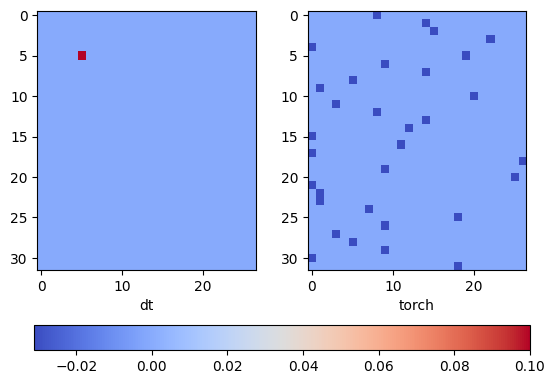

In [12]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------

cmp("logprobs", dlogprobs, logprobs)
# cmp('probs', dprobs, probs)
# cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
# cmp('counts_sum', dcounts_sum, counts_sum)
# cmp('counts', dcounts, counts)
# cmp('norm_logits', dnorm_logits, norm_logits)
# cmp('logit_maxes', dlogit_maxes, logit_maxes)
# cmp('logits', dlogits, logits)
# cmp('h', dh, h)
# cmp('W2', dW2, W2)
# cmp('b2', db2, b2)
# cmp('hpreact', dhpreact, hpreact)
# cmp('bngain', dbngain, bngain)
# cmp('bnbias', dbnbias, bnbias)
# cmp('bnraw', dbnraw, bnraw)
# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)